# EXP 1

In [7]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [8]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

# KMNIST

In [9]:
NUM_EPOCHS = 10
batch_size = 64
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_set = datasets.KMNIST('data', train=True, transform=trans, download=True)
test_set = datasets.KMNIST('data', train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=True)

In [10]:
from torchvision import models
from torchsummary import summary

class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.bn  = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.fc1 = nn.Linear(4*4*20, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

summary(model, input_size = torch.Size([1, 28, 28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
       BatchNorm2d-2           [-1, 10, 12, 12]              20
            Conv2d-3             [-1, 20, 8, 8]           5,020
            Linear-4                  [-1, 500]         160,500
            Linear-5                   [-1, 10]           5,010
Total params: 170,810
Trainable params: 170,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.65
Estimated Total Size (MB): 0.72
----------------------------------------------------------------


### 1. Real Net

In [11]:
class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.bn  = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.fc1 = nn.Linear(4*4*20, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.313002	Accuracy: 4.69%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.806452	Accuracy: 64.09%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.372290	Accuracy: 75.34%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.227996	Accuracy: 80.44%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.227453	Accuracy: 83.62%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.133910	Accuracy: 85.72%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.114344	Accuracy: 87.20%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.195786	Accuracy: 88.32%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.097344	Accuracy: 89.17%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.233293	Accuracy: 89.89%
Epoch 0 - Time: 22.80s - Train Loss: 0.315204 - Train Accuracy: 90.15%
Test Loss: 0.309874 - Test Accuracy: 90.81%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.087023	Accuracy: 96.88%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.137016	Accuracy: 97.42%
Train Epoch:   1 [ 12

### 2. Complex Net

In [12]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 5, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 5, 1)
        self.fc1 = ComplexLinear(4*4*20, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.391404	Accuracy: 12.50%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.461107	Accuracy: 74.86%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.312503	Accuracy: 83.39%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.217934	Accuracy: 86.70%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.041353	Accuracy: 88.74%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.310250	Accuracy: 90.19%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.089487	Accuracy: 91.18%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.299516	Accuracy: 91.87%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.059019	Accuracy: 92.48%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.182976	Accuracy: 93.00%
Epoch 0 - Time: 108.25s - Train Loss: 0.219622 - Train Accuracy: 93.16%
Test Loss: 0.258102 - Test Accuracy: 92.16%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.142639	Accuracy: 95.31%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.012637	Accuracy: 98.08%
Train Epoch:   1 [ 

### 3. Functional changes!

In [13]:
def add_random_small_complex_number(data, small_value=1e-5):
    # Generates a random complex number with small magnitudes
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    small_complex = torch.complex(real_part, imag_part)
    return data + small_complex

def add_fixed_phase(data, phase_value=0.5):
    # Adds a fixed phase to each complex number
    phase_value = torch.tensor(phase_value)
    phase_complex = torch.complex(torch.cos(phase_value), torch.sin(phase_value))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    # Adds a fixed imaginary component to each complex number
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e3 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e3,
          data_fn = add_random_small_complex_number)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.389529	Accuracy: 12.50%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.463788	Accuracy: 74.80%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.413487	Accuracy: 83.05%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.166335	Accuracy: 86.58%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.294534	Accuracy: 88.50%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.236398	Accuracy: 89.88%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.265461	Accuracy: 90.91%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.127044	Accuracy: 91.72%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.386051	Accuracy: 92.33%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.364922	Accuracy: 92.88%
Epoch 0 - Time: 113.05s - Train Loss: 0.220486 - Train Accuracy: 93.06%
Test Loss: 0.241255 - Test Accuracy: 93.26%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.045028	Accuracy: 98.44%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.105931	Accuracy: 97.99%
Train Epoch:   1 [ 

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e4 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e4,
          data_fn = add_fixed_imaginary_component)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e4.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.353434	Accuracy: 15.62%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.497161	Accuracy: 77.49%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.234907	Accuracy: 84.47%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.332363	Accuracy: 87.60%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.107246	Accuracy: 89.43%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.275193	Accuracy: 90.80%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.182438	Accuracy: 91.68%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.063569	Accuracy: 92.32%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.163596	Accuracy: 92.87%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.237352	Accuracy: 93.30%
Epoch 0 - Time: 114.16s - Train Loss: 0.210191 - Train Accuracy: 93.44%
Test Loss: 0.305704 - Test Accuracy: 90.88%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.060216	Accuracy: 98.44%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.084108	Accuracy: 98.17%
Train Epoch:   1 [ 

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e5 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e5,
          data_fn = add_fixed_phase)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e5.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.324599	Accuracy: 15.62%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.459379	Accuracy: 75.65%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.246235	Accuracy: 83.40%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.217700	Accuracy: 86.83%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.063303	Accuracy: 88.97%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.046125	Accuracy: 90.36%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.221243	Accuracy: 91.31%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.321855	Accuracy: 92.02%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.081546	Accuracy: 92.63%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.144392	Accuracy: 93.09%
Epoch 0 - Time: 116.23s - Train Loss: 0.216599 - Train Accuracy: 93.25%
Test Loss: 0.870019 - Test Accuracy: 74.59%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.025788	Accuracy: 100.00%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.063806	Accuracy: 98.14%
Train Epoch:   1 [

# Plots

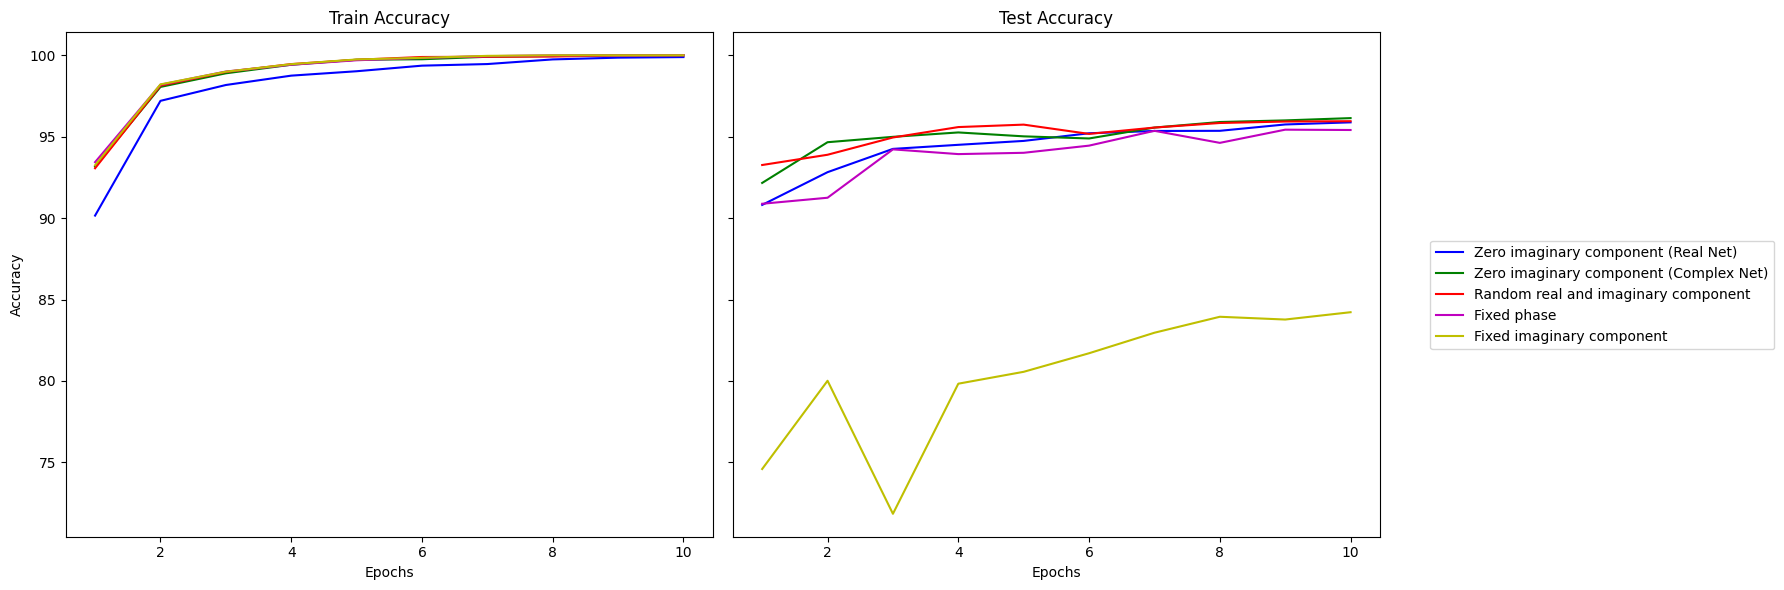

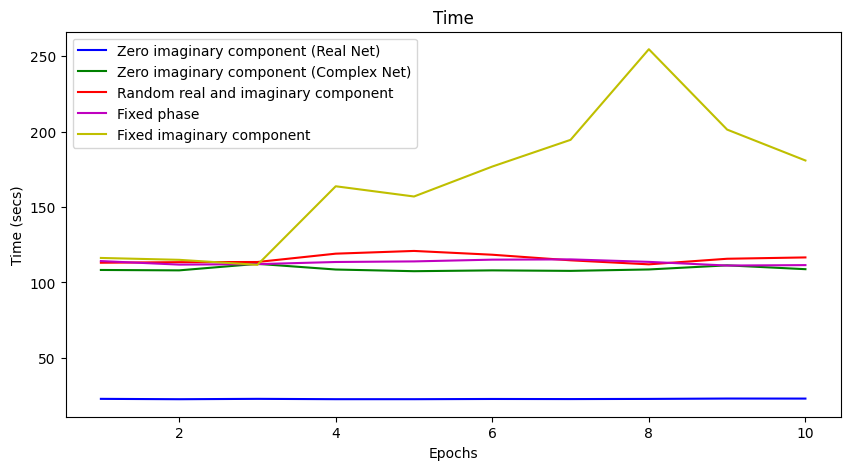

In [23]:
# Data for the five scenarios
data = {
    "Zero imaginary component (Real Net)": metrics_dict_e1,
    "Zero imaginary component (Complex Net)": metrics_dict_e2,
    "Random real and imaginary component": metrics_dict_e3,
    "Fixed phase": metrics_dict_e4,
    "Fixed imaginary component": metrics_dict_e5
}

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y']
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for i, scenario in enumerate(scenarios):
    axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
axes.set_title("Time")
axes.set_xlabel("Epochs")
axes.set_ylabel("Time (secs)")
axes.legend()


In [21]:
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss (log scale)")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].set_yscale('log')
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss (log scale)")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].set_yscale('log')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

### Activation Comparison

In [24]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)  # Prevent exploding gradients
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd

# ---------- Complex Activation Functions ----------
def complex_relu(z):
    return F.relu(z.real).type(torch.complex64) + 1j * F.relu(z.imag).type(torch.complex64)

def modrelu(z, b=0.1):
    magnitude = torch.abs(z)
    phase = z / (magnitude + 1e-8)
    scale = F.relu(magnitude + b)
    return scale * phase

def zrelu(z):
    mask = (z.real >= 0) & (z.imag >= 0)
    return z * mask

def smooth_zrelu(z, alpha=1.0):
    real_mask = torch.sigmoid(alpha * z.real)
    imag_mask = torch.sigmoid(alpha * z.imag)
    smooth_mask = real_mask * imag_mask
    return z * smooth_mask

def split_tanh(z):
    return torch.tanh(z.real).type(torch.complex64) + 1j * torch.tanh(z.imag).type(torch.complex64)

def complex_cardioid(z, eps=1e-5):
    norm = torch.abs(z)
    cos_phase = z.real / (norm + eps)  # cos(theta)
    scale = 0.5 * (1 + cos_phase)
    return z * scale

# ---------- Data Transformations ----------
def add_random_small_complex_number(data, small_value=1e-5):
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    return data + torch.complex(real_part, imag_part)

def add_fixed_phase(data, phase_value=0.5):
    phase_complex = torch.complex(torch.cos(torch.tensor(phase_value)), torch.sin(torch.tensor(phase_value)))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

# ---------- Model ----------
class ComplexNet(nn.Module):
    def __init__(self, activation_fn):
        super(ComplexNet, self).__init__()
        self.activation_fn = activation_fn
        self.conv1 = ComplexConv2d(1, 32, 5, 1)
        self.bn  = ComplexBatchNorm2d(32)
        self.conv2 = ComplexConv2d(32, 64, 5, 1)
        self.fc1 = ComplexLinear(4*4*64, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

# ---------- Evaluation Function ----------
def evaluate_combination(activation_name, activation_fn, data_fn_name, data_fn, NUM_EPOCHS=5):
    model = ComplexNet(activation_fn).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    metrics_dict = {
        'epoch_times': [],
        'train_losses': [],
        'train_accuracies': [],
        'test_losses': [],
        'test_accuracies': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Activation: {activation_name}, Data Transformation: {data_fn_name}")
        train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict,
              complexify=True, data_fn=data_fn)

    return {
        'Activation': activation_name,
        'Data Transformation': data_fn_name,
        'Train Loss': sum(metrics_dict['train_losses']) / NUM_EPOCHS,
        'Train Accuracy': sum(metrics_dict['train_accuracies']) / NUM_EPOCHS,
        'Test Loss': sum(metrics_dict['test_losses']) / NUM_EPOCHS,
        'Test Accuracy': sum(metrics_dict['test_accuracies']) / NUM_EPOCHS,
        'Avg Epoch Time (s)': sum(metrics_dict['epoch_times']) / NUM_EPOCHS
    }

# ---------- Setup ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

activation_functions = {
    "CReLU": complex_relu,
    "modReLU": lambda z: modrelu(z, b=0.1),
    "zReLU": smooth_zrelu,
    "split_tanh": split_tanh,
    "cardioid": complex_cardioid
}

data_transformations = {
    "None": None,
    "Small Random Complex Noise": add_random_small_complex_number,
    "Fixed Phase (0.5)": add_fixed_phase,
    "Fixed Imaginary (0.1)": add_fixed_imaginary_component
}

In [26]:
results = []

act_name = "CReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_crelu = pd.DataFrame(results)

Running: Activation = CReLU, Data Transform = None
Epoch 1/5 - Activation: CReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.375242	Accuracy: 14.06%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.153995	Accuracy: 80.06%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.057444	Accuracy: 86.19%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.121811	Accuracy: 88.81%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.370399	Accuracy: 90.52%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.030766	Accuracy: 91.59%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.093049	Accuracy: 92.44%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.017727	Accuracy: 93.02%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.053980	Accuracy: 93.52%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.033362	Accuracy: 93.93%
Epoch 0 - Time: 196.72s - Train Loss: 0.189333 - Train Accuracy: 94.07%
Test Loss: 0.259552 - Test Accuracy: 92.80%

Epoch 2/5 - Activation: CReLU, Data Transformation: Non

In [27]:
results = []

act_name = "modReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_modrelu = pd.DataFrame(results)

Running: Activation = modReLU, Data Transform = None
Epoch 1/5 - Activation: modReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.660533	Accuracy: 4.69%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 1.034953	Accuracy: 67.11%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 1.893693	Accuracy: 71.42%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 1.551137	Accuracy: 73.77%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 1.896994	Accuracy: 75.42%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 1.526716	Accuracy: 76.68%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 1.170884	Accuracy: 78.12%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.245777	Accuracy: 79.73%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.189966	Accuracy: 81.21%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.316044	Accuracy: 82.39%
Epoch 0 - Time: 208.55s - Train Loss: 0.995588 - Train Accuracy: 82.79%
Test Loss: 0.620731 - Test Accuracy: 84.27%

Epoch 2/5 - Activation: modReLU, Data Transformation

In [33]:
results = []

act_name = "zReLU"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_zrelu = pd.DataFrame(results)

Running: Activation = zReLU, Data Transform = None
Epoch 1/5 - Activation: zReLU, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.316707	Accuracy: 9.38%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.311745	Accuracy: 72.17%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.110525	Accuracy: 82.25%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.166659	Accuracy: 86.39%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.216073	Accuracy: 88.68%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.113867	Accuracy: 90.17%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.146814	Accuracy: 91.31%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.041407	Accuracy: 92.13%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.018900	Accuracy: 92.81%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.017634	Accuracy: 93.28%
Epoch 0 - Time: 206.25s - Train Loss: 0.211678 - Train Accuracy: 93.43%
Test Loss: 0.209204 - Test Accuracy: 94.11%

Epoch 2/5 - Activation: zReLU, Data Transformation: None

In [29]:
results = []

act_name = "split_tanh"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_split_tanh = pd.DataFrame(results)

Running: Activation = split_tanh, Data Transform = None
Epoch 1/5 - Activation: split_tanh, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.371761	Accuracy: 7.81%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.617642	Accuracy: 73.61%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.355438	Accuracy: 80.60%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.279980	Accuracy: 83.88%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.292601	Accuracy: 85.83%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.279742	Accuracy: 87.17%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.221222	Accuracy: 88.13%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.229709	Accuracy: 88.80%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.153054	Accuracy: 89.49%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.062562	Accuracy: 90.04%
Epoch 0 - Time: 193.38s - Train Loss: 0.318923 - Train Accuracy: 90.19%
Test Loss: 0.410153 - Test Accuracy: 87.96%

Epoch 2/5 - Activation: split_tanh, Data Trans

In [40]:
results = []

act_name = "cardioid"
act_fn = activation_functions[act_name]

for data_name, data_fn in data_transformations.items():
    print(f"Running: Activation = {act_name}, Data Transform = {data_name}")
    result = evaluate_combination(act_name, act_fn, data_name, data_fn)
    results.append(result)

df_cardioid = pd.DataFrame(results)

Running: Activation = cardioid, Data Transform = None
Epoch 1/5 - Activation: cardioid, Data Transformation: None
Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.346690	Accuracy: 10.94%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.172635	Accuracy: 80.58%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.237760	Accuracy: 86.92%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.149748	Accuracy: 89.78%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.142974	Accuracy: 91.20%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.053820	Accuracy: 92.30%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.079115	Accuracy: 93.07%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.064583	Accuracy: 93.67%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.180112	Accuracy: 94.16%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.051905	Accuracy: 94.59%
Epoch 0 - Time: 191.31s - Train Loss: 0.173175 - Train Accuracy: 94.71%
Test Loss: 0.221753 - Test Accuracy: 93.86%

Epoch 2/5 - Activation: cardioid, Data Transforma

In [41]:
df_results = pd.concat([df_crelu, df_modrelu, df_zrelu, df_split_tanh, df_cardioid], ignore_index=True)
print("\nFinal Results Summary:\n")
print(df_results.to_string(index=False))


Final Results Summary:

Activation        Data Transformation  Train Loss  Train Accuracy  Test Loss  Test Accuracy  Avg Epoch Time (s)
     CReLU                       None    0.053475       98.344000   0.205773         94.870          196.277682
     CReLU Small Random Complex Noise    0.054440       98.321000   0.188242         95.168          196.279920
     CReLU          Fixed Phase (0.5)    0.053693       98.325667   0.507947         86.022          194.133415
     CReLU      Fixed Imaginary (0.1)    0.056037       98.266000   0.238285         93.866          193.699938
   modReLU                       None    0.299050       93.475000   0.461591         88.112          210.105431
   modReLU Small Random Complex Noise    0.292508       93.798000   0.436182         88.628          210.091441
   modReLU          Fixed Phase (0.5)    0.299639       93.603333   3.057494         46.778          209.398491
   modReLU      Fixed Imaginary (0.1)    0.296439       93.611000   5.056978   